In [2]:
## load libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, classification_report, precision_recall_curve
import joblib


In [3]:
## load the dataset
dffraud = pd.read_csv("PS_20174392719_1491204439457_log.csv")
dffraud.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
## info for missing value and data type
dffraud.info()

# great number of observations
# existing numeric and non-numeric variables
# slow loading for huge amount of entries thus need to cut down on data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
## Basic statistics summary of all variables in dataset
dffraud.describe().apply(lambda s: s.apply('{0:.4f}'.format))

## inbalanced dataset with more than 75% online payment not being fraud
## great difference in balance figures from observation to observation

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.0000,6362620.0000,6362620.0000,6362620.0000,6362620.0000,6362620.0000,6362620.0000,6362620.0000
mean,243.3972,179861.9035,833883.1041,855113.6686,1100701.6665,1224996.3982,0.0013,0.0000
std,142.3320,603858.2315,2888242.6730,2924048.5030,3399180.1130,3674128.9421,0.0359,0.0016
min,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,156.0000,13389.5700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,239.0000,74871.9400,14208.0000,0.0000,132705.6650,214661.4400,0.0000,0.0000
75%,335.0000,208721.4775,107315.1750,144258.4100,943036.7075,1111909.2500,0.0000,0.0000
max,743.0000,92445516.6400,59585040.3700,49585040.3700,356015889.3500,356179278.9200,1.0000,1.0000


In [6]:
## check missing values
print(dffraud.isnull().sum())
# no missing value, great!

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [7]:
## optimise the efficiency by changing some data types
dffraud_op = dffraud.copy()
for column in dffraud.columns:
    if dffraud[column].dtype == 'int64':
        dffraud_op[column] = dffraud[column].astype('int16')
    if dffraud[column].dtype == 'float64':
        dffraud_op[column] = dffraud[column].astype('float32')


In [8]:
## Looking at data types again
dffraud_op.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int16  
 1   type            object 
 2   amount          float32
 3   nameOrig        object 
 4   oldbalanceOrg   float32
 5   newbalanceOrig  float32
 6   nameDest        object 
 7   oldbalanceDest  float32
 8   newbalanceDest  float32
 9   isFraud         int16  
 10  isFlaggedFraud  int16  
dtypes: float32(5), int16(3), object(3)
memory usage: 303.4+ MB


0    6354407
1       8213
Name: isFraud, dtype: int64


Text(0.5, 1.0, 'Pie Chart for Fraud and Not Fraud Distribution')

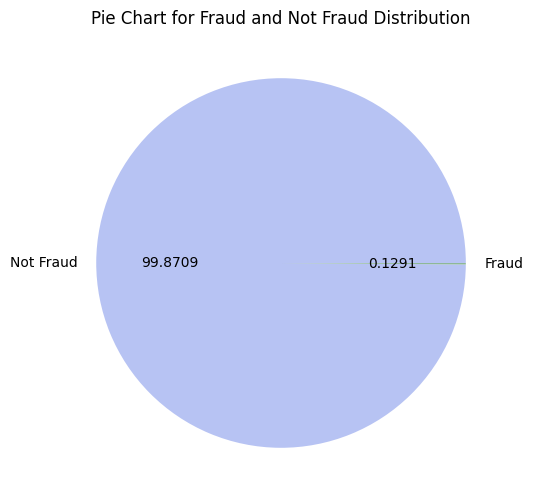

In [9]:
## Check the variable: isFraud
print(dffraud_op.isFraud.value_counts())
labels = ['Not Fraud','Fraud']
colors = ['#B7C3F3', '#8EB897']
fig, ax = plt.subplots(figsize=(8,6))
dffraud_op.groupby('isFraud').size().plot(kind='pie', autopct='%.4f', labels=labels,colors=colors)
plt.title("Pie Chart for Fraud and Not Fraud Distribution")
# super unbalanced and need to mitigate for more precise prediction

[Text(0.5, 1.0, 'Step Distribution among Online Payments')]

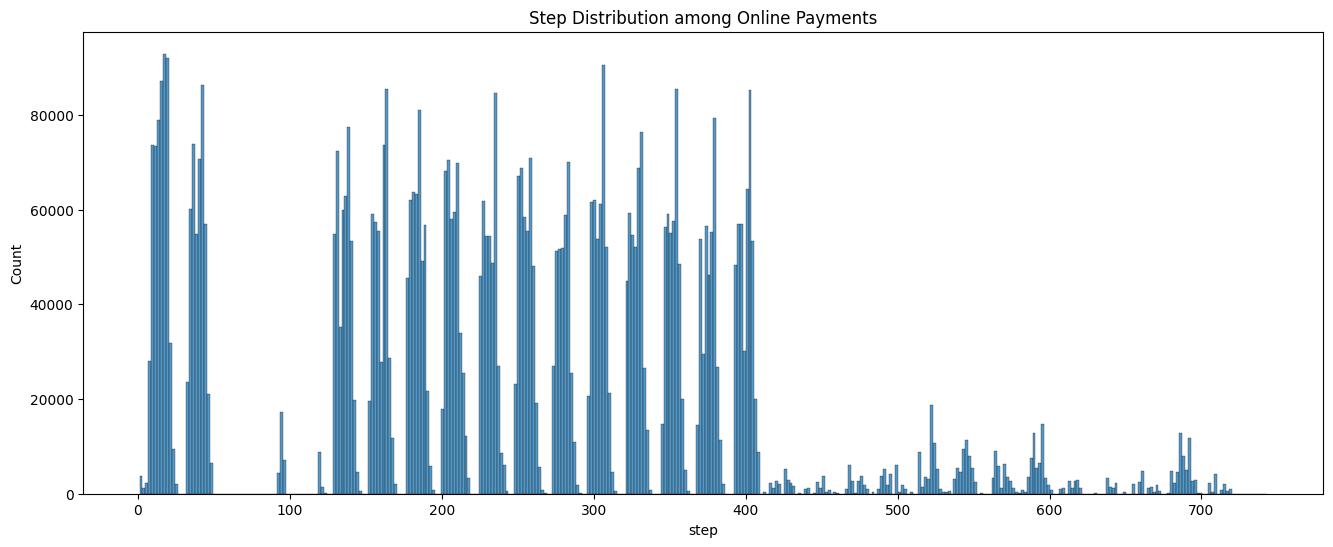

In [10]:
## Check the variable: Step
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(data=dffraud_op, x=dffraud_op["step"],kde=False).set( title="Step Distribution among Online Payments")
## not normally distributed as the rapid online payment is extraordinarily common shorter than 50 hours
## need to compensate it by standard scaling 

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0.5, 1.0, 'Oneline Payment Type Distribution Pie Chart')

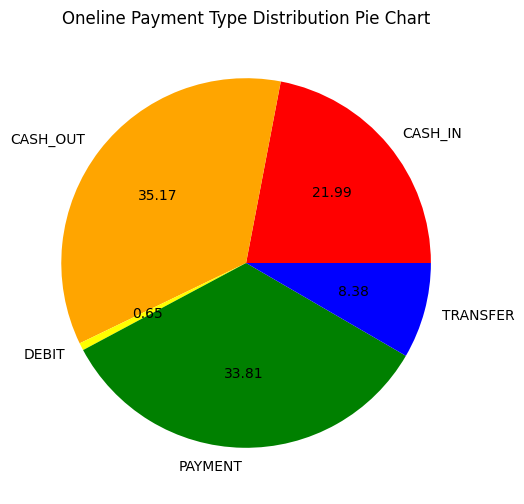

In [11]:
## Check the variable: type
print(dffraud_op.type.value_counts())
labels = ['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER']
colors = ['red','orange','yellow','green','blue']
fig, ax = plt.subplots(figsize=(8,6))
dffraud_op.groupby('type').size().plot(kind='pie', autopct='%.2f', labels=labels,colors=colors)
plt.title("Oneline Payment Type Distribution Pie Chart")

Text(0.5, 0, 'amount')

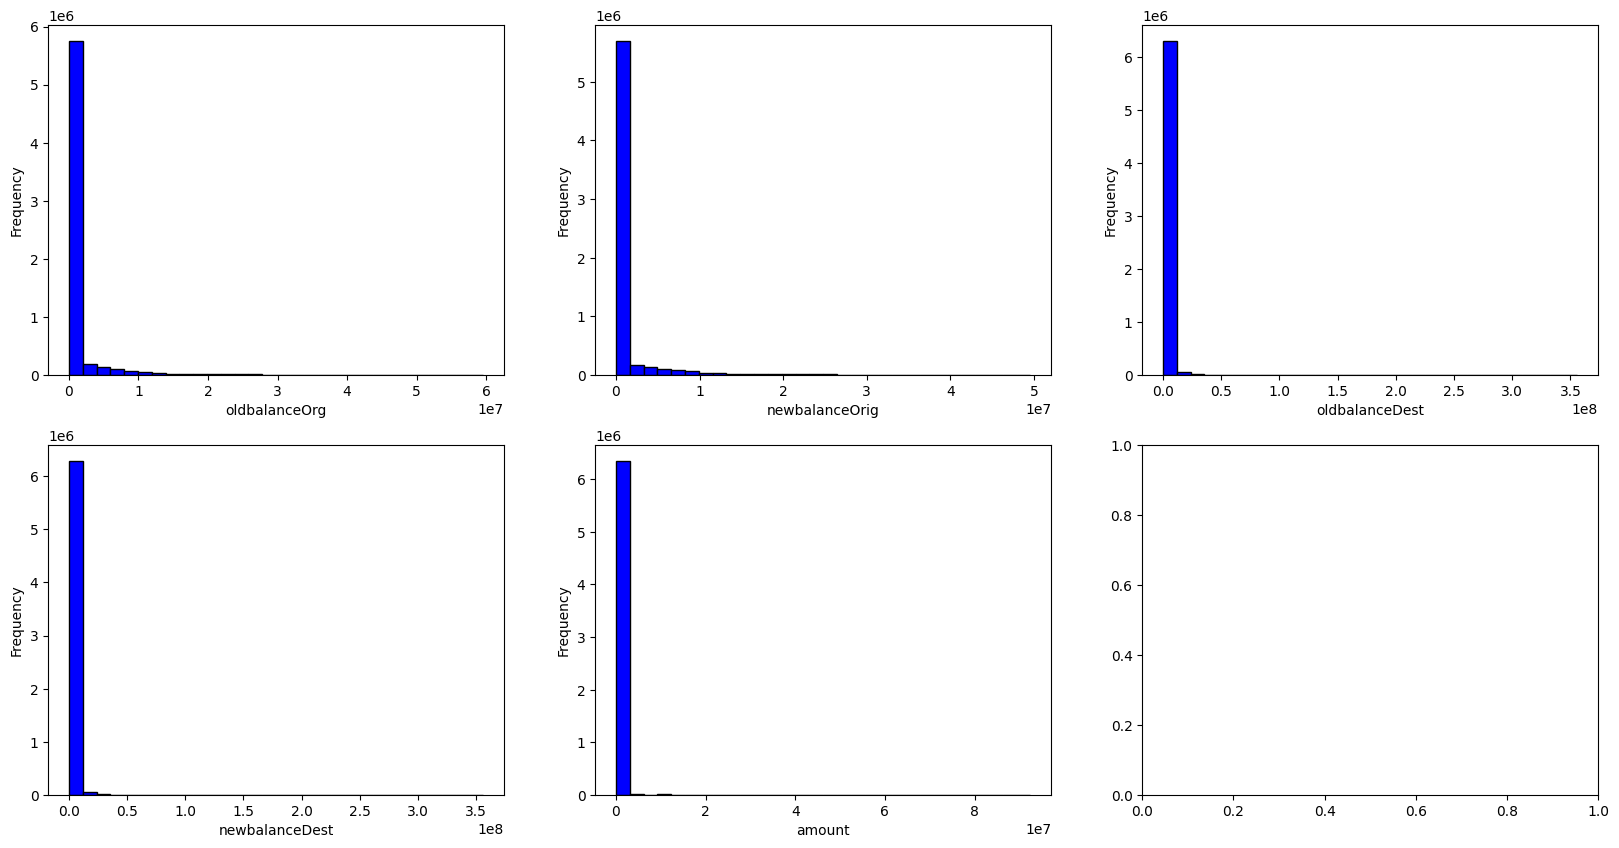

In [12]:
## check the variables: oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, amount
fig, ax = plt.subplots(2,3,figsize=(20,10))
dffraud_op['oldbalanceOrg'].plot(ax=ax[0,0],kind='hist', bins=30, facecolor='blue',edgecolor='black')
ax[0,0].set_xlabel("oldbalanceOrg")
dffraud_op['newbalanceOrig'].plot(ax=ax[0,1],kind='hist', bins=30, facecolor='blue',edgecolor='black')
ax[0,1].set_xlabel("newbalanceOrig")
dffraud_op['oldbalanceDest'].plot(ax=ax[0,2],kind='hist', bins=30, facecolor='blue',edgecolor='black')
ax[0,2].set_xlabel("oldbalanceDest")
dffraud_op['newbalanceDest'].plot(ax=ax[1,0],kind='hist', bins=30, facecolor='blue',edgecolor='black')
ax[1,0].set_xlabel("newbalanceDest")
dffraud_op['amount'].plot(ax=ax[1,1],kind='hist', bins=30, facecolor='blue',edgecolor='black')
ax[1,1].set_xlabel("amount")
## highly abnormal, need standard scaler

isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097


Text(0.5, 1.0, 'Type Distribution among Online Payments Frauds')

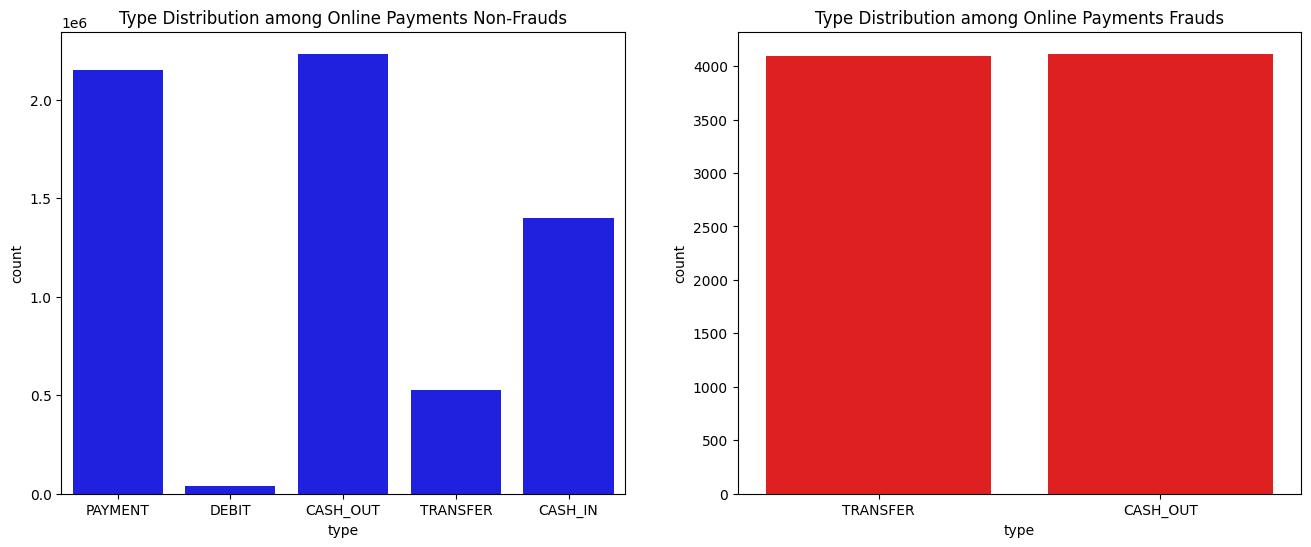

In [13]:
## type by isFraud
print(pd.crosstab(index=dffraud_op.type,columns=dffraud_op.isFraud))
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.countplot(ax=ax[0], x= dffraud_op["type"][dffraud_op.isFraud== 0],color="blue")
ax[0].set_title("Type Distribution among Online Payments Non-Frauds")
sns.countplot(ax=ax[1], x= dffraud_op["type"][dffraud_op.isFraud== 1], color="red")
ax[1].set_title("Type Distribution among Online Payments Frauds")

[Text(0.5, 1.0, 'Amount Distribution among Online Payment Frauds')]

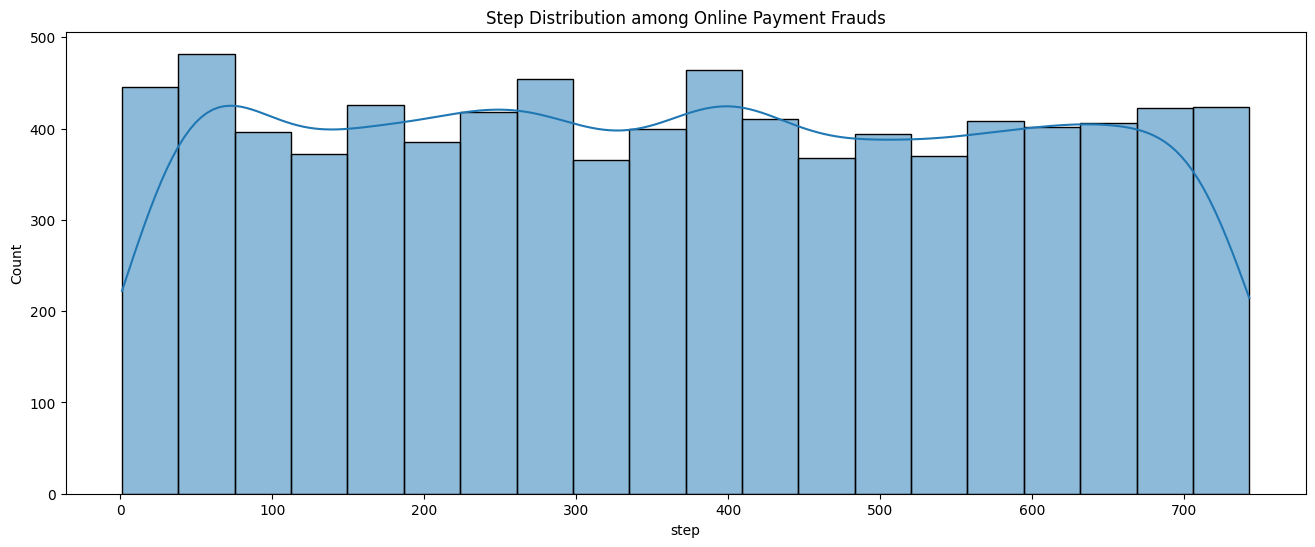

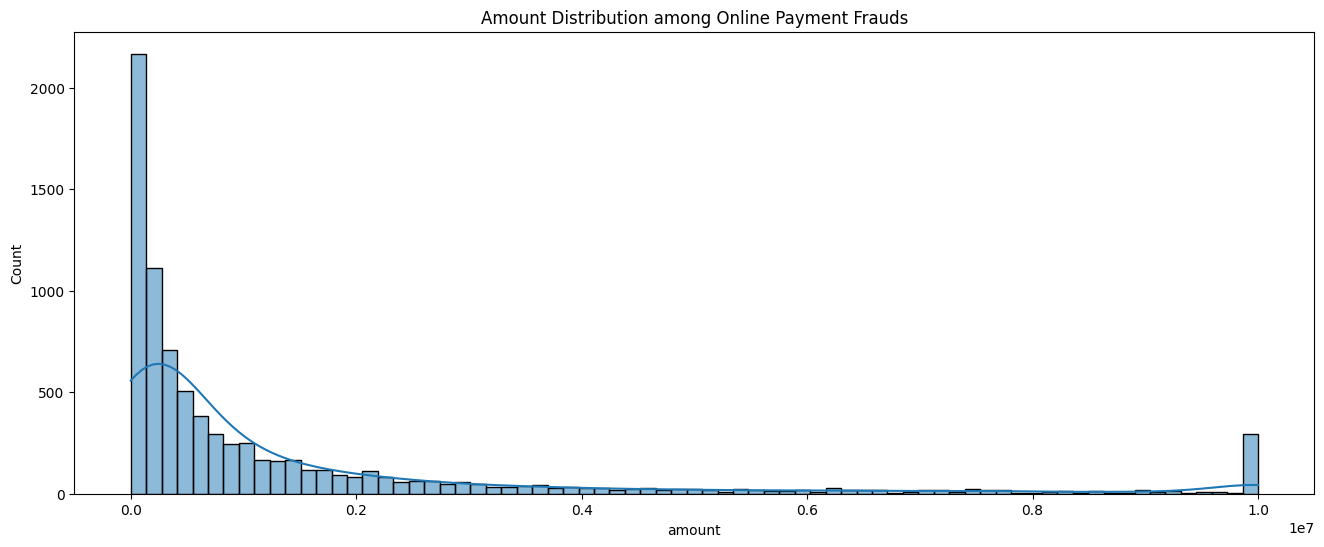

In [14]:
## check step and amount by isFraud
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(data=dffraud_op, x=dffraud_op["step"][dffraud_op.isFraud== 1],kde=True).set( title="Step Distribution among Online Payment Frauds")
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(data=dffraud_op, x=dffraud_op["amount"][dffraud_op.isFraud== 1],kde=True).set( title="Amount Distribution among Online Payment Frauds")

In [15]:
## Transform into dummy: type
dffraud_op = pd.get_dummies(dffraud, columns=["type"])

C:\Users\mmm\AppData\Local\Temp\ipykernel_26076\569482616.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mt = dffraud_op.corr()


                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.022373      -0.010058       -0.010299   
amount          0.022373  1.000000      -0.002762       -0.007861   
oldbalanceOrg  -0.010058 -0.002762       1.000000        0.998803   
newbalanceOrig -0.010299 -0.007861       0.998803        1.000000   
oldbalanceDest  0.027665  0.294137       0.066243        0.067812   
newbalanceDest  0.025888  0.459304       0.042029        0.041837   
isFraud         0.031578  0.076688       0.010154       -0.008148   
isFlaggedFraud  0.003277  0.012295       0.003835        0.003776   
type_CASH_IN    0.004077 -0.009621       0.506761        0.527373   
type_CASH_OUT  -0.012918 -0.004376      -0.200899       -0.210977   
type_DEBIT      0.002869 -0.023379      -0.021450       -0.021872   
type_PAYMENT    0.004926 -0.197444      -0.189486       -0.193915   
type_TRANSFER   0.006925  0.365896      -0.081593       -0.087355   

                oldbalanceDest  n

<AxesSubplot: >

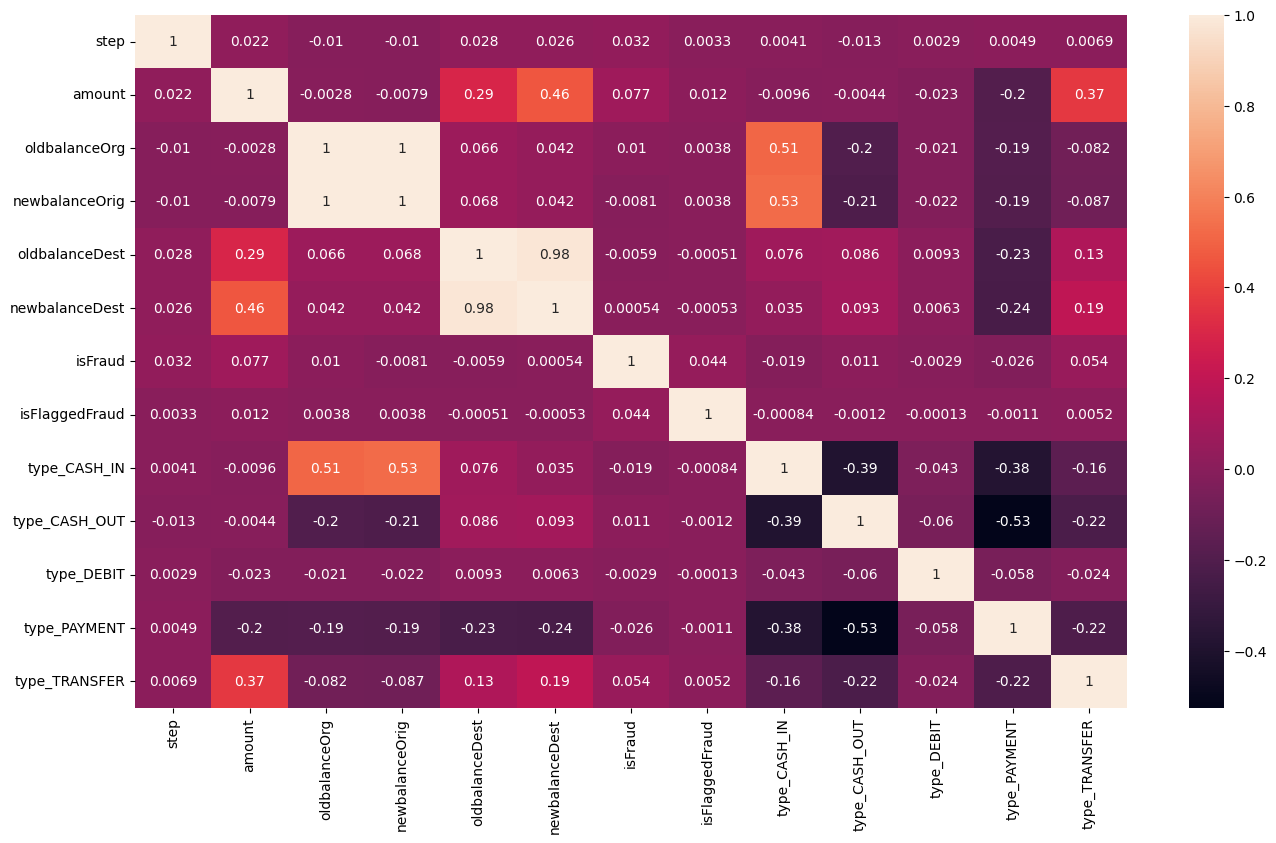

In [16]:
## Correlation Matrix 
mt = dffraud_op.corr()
print(mt)
fig, ax=plt.subplots(figsize=(16,9))
sns.heatmap(mt, annot=True, square=False)

In [17]:
## remove outliers in oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest, amount
print("oldbalanceOrg Highest allowed",dffraud_op['oldbalanceOrg'].mean() + 3*dffraud_op['oldbalanceOrg'].std())
print("oldbalanceOrg Lowest allowed",dffraud_op['oldbalanceOrg'].mean() - 3*dffraud_op['oldbalanceOrg'].std())
print("newbalanceOrig Highest allowed",dffraud_op['newbalanceOrig'].mean() + 3*dffraud_op['newbalanceOrig'].std())
print("newbalanceOrig Lowest allowed",dffraud_op['newbalanceOrig'].mean() - 3*dffraud_op['newbalanceOrig'].std())
print("oldbalanceDest Highest allowed",dffraud_op['oldbalanceDest'].mean() + 3*dffraud_op['oldbalanceDest'].std())
print("oldbalanceDest Lowest allowed",dffraud_op['oldbalanceDest'].mean() - 3*dffraud_op['oldbalanceDest'].std())
print("newbalanceDest Highest allowed",dffraud_op['newbalanceDest'].mean() + 3*dffraud_op['newbalanceDest'].std())
print("newbalanceDest Lowest allowed",dffraud_op['newbalanceDest'].mean() - 3*dffraud_op['newbalanceDest'].std())
print("amount Highest allowed",dffraud_op['amount'].mean() + 3*dffraud_op['amount'].std())
print("amount Lowest allowed",dffraud_op['amount'].mean() - 3*dffraud_op['amount'].std())
dffraud_op_out = dffraud_op[(dffraud_op['oldbalanceOrg'] < 5424343) & (dffraud_op['oldbalanceOrg'] > -4251019)]
dffraud_op_out = dffraud_op[(dffraud_op['newbalanceOrig'] < 6792194) & (dffraud_op['newbalanceOrig'] > -5390989)]
dffraud_op_out = dffraud_op[(dffraud_op['oldbalanceDest'] < 11298242) & (dffraud_op['oldbalanceDest'] > -9096839)]
dffraud_op_out = dffraud_op[(dffraud_op['newbalanceDest'] < 12247383) & (dffraud_op['newbalanceDest'] > -9797390)]
dffraud_op_out = dffraud_op[(dffraud_op['amount'] < 1991437) & (dffraud_op['amount'] > -1631713)]
oldbalanceOrg_cap = dffraud_op['oldbalanceOrg'].mean() + 3*dffraud_op['oldbalanceOrg'].std()
oldbalanceOrg_floor = dffraud_op['oldbalanceOrg'].mean() - 3*dffraud_op['oldbalanceOrg'].std()
newbalanceOrig_cap = dffraud_op['newbalanceOrig'].mean() + 3*dffraud_op['newbalanceOrig'].std()
newbalanceOrig_floor = dffraud_op['newbalanceOrig'].mean() - 3*dffraud_op['newbalanceOrig'].std()
oldbalanceDest_cap = dffraud_op['oldbalanceDest'].mean() + 3*dffraud_op['oldbalanceDest'].std()
oldbalanceDest_floor = dffraud_op['oldbalanceDest'].mean() - 3*dffraud_op['oldbalanceDest'].std()
newbalanceDest_cap = dffraud_op['newbalanceDest'].mean() + 3*dffraud_op['newbalanceDest'].std()
newbalanceDest_floor = dffraud_op['newbalanceDest'].mean() - 3*dffraud_op['newbalanceDest'].std()
amount_cap = dffraud_op['amount'].mean() + 3*dffraud_op['amount'].std()
amount_floor = dffraud_op['amount'].mean() - 3*dffraud_op['amount'].std()
dffraud_op['oldbalanceOrg'] = np.where(
    dffraud_op['oldbalanceOrg']>oldbalanceOrg_cap,
    oldbalanceOrg_cap,
    np.where(
        dffraud_op['oldbalanceOrg']<oldbalanceOrg_floor,
        oldbalanceOrg_floor,
        dffraud_op['oldbalanceOrg']))
dffraud_op['newbalanceOrig'] = np.where(
   dffraud_op['newbalanceOrig']>newbalanceOrig_cap,
    newbalanceOrig_cap,
    np.where(
        dffraud_op['newbalanceOrig']<newbalanceOrig_floor,
        newbalanceOrig_floor,
        dffraud_op['newbalanceOrig']))
dffraud_op['oldbalanceDest'] = np.where(
   dffraud_op['oldbalanceDest']>oldbalanceDest_cap,
    oldbalanceDest_cap,
    np.where(
        dffraud_op['oldbalanceDest']<oldbalanceDest_floor,
        oldbalanceDest_floor,
        dffraud_op['oldbalanceDest']))
dffraud_op['newbalanceDest'] = np.where(
   dffraud_op['newbalanceDest']>newbalanceDest_cap,
    newbalanceDest_cap,
    np.where(
        dffraud_op['newbalanceDest']<newbalanceDest_floor,
        newbalanceDest_floor,
        dffraud_op['newbalanceDest']))
dffraud_op['amount'] = np.where(
   dffraud_op['amount']>amount_cap,
    amount_cap,
    np.where(
        dffraud_op['amount']<amount_floor,
        amount_floor,
        dffraud_op['amount']))

oldbalanceOrg Highest allowed 9498611.123187155
oldbalanceOrg Lowest allowed -7830844.915038181
newbalanceOrig Highest allowed 9627259.177441387
newbalanceOrig Lowest allowed -7917031.8402842125
oldbalanceDest Highest allowed 11298242.005503079
oldbalanceDest Lowest allowed -9096838.67246378
newbalanceDest Highest allowed 12247383.224560836
newbalanceDest Lowest allowed -9797390.428156978
amount Highest allowed 1991436.597937938
amount Lowest allowed -1631712.7908396765


In [18]:
## Looking at data types again again
dffraud_op_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6317675 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  type_CASH_IN    uint8  
 11  type_CASH_OUT   uint8  
 12  type_DEBIT      uint8  
 13  type_PAYMENT    uint8  
 14  type_TRANSFER   uint8  
dtypes: float64(5), int64(3), object(2), uint8(5)
memory usage: 560.3+ MB


In [19]:
## balance the dataset 
nisFraud_0, nisFraud_1 = dffraud_op_out['isFraud'].value_counts()

# Separate class
isFraud_0 = dffraud_op_out[dffraud_op_out['isFraud'] == 0]
isFraud_1 = dffraud_op_out[dffraud_op_out['isFraud'] == 1]# print the shape of the class
print('class 0:', isFraud_0.shape)
print('class 1:', isFraud_1.shape)

isFraud_0_under = isFraud_0.sample(nisFraud_1)
bdffraud_op_out = pd.concat([isFraud_0_under,isFraud_1],axis=0)

class 0: (6311148, 15)
class 1: (6527, 15)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13054 entries, 4219033 to 6362619
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            13054 non-null  int64  
 1   amount          13054 non-null  float64
 2   nameOrig        13054 non-null  object 
 3   oldbalanceOrg   13054 non-null  float64
 4   newbalanceOrig  13054 non-null  float64
 5   nameDest        13054 non-null  object 
 6   oldbalanceDest  13054 non-null  float64
 7   newbalanceDest  13054 non-null  float64
 8   isFraud         13054 non-null  int64  
 9   isFlaggedFraud  13054 non-null  int64  
 10  type_CASH_IN    13054 non-null  uint8  
 11  type_CASH_OUT   13054 non-null  uint8  
 12  type_DEBIT      13054 non-null  uint8  
 13  type_PAYMENT    13054 non-null  uint8  
 14  type_TRANSFER   13054 non-null  uint8  
dtypes: float64(5), int64(3), object(2), uint8(5)
memory usage: 1.2+ MB
None


<AxesSubplot: title={'center': 'count (target)'}>

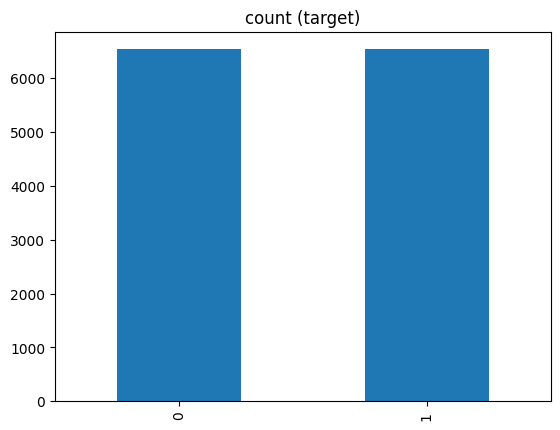

In [20]:
## balanced data
print(bdffraud_op_out.info())
bdffraud_op_out['isFraud'].value_counts().plot(kind='bar', title='count (target)')

In [21]:
## set model x and y
x = bdffraud_op_out[['step', 'amount', 'oldbalanceOrg','oldbalanceDest','type_CASH_IN','type_CASH_OUT','type_PAYMENT','type_TRANSFER']].values
y = bdffraud_op_out[['isFraud']].values

In [22]:
## split and scaling 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=114514)
scaler= StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [23]:
## Logistic Regression
model_LR = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100)
model_LR.fit(x_train, y_train)
y_pred = model_LR.predict(x_test)
print(model_LR.coef_)
## accuracy score
print(accuracy_score(y_test,y_pred))
## confusion matrix
mat = confusion_matrix(y_test, y_pred)
print(mat)
print(classification_report(y_test,y_pred))


[[  0.62869979  -0.3119679    5.85950963  -0.2990025  -18.14777828
    6.33651333  -0.7318074    6.45215419]]
0.8544804697472556
[[1594  380]
 [ 190 1753]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1974
           1       0.82      0.90      0.86      1943

    accuracy                           0.85      3917
   macro avg       0.86      0.85      0.85      3917
weighted avg       0.86      0.85      0.85      3917



c:\Users\mmm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
## KNN
model_KNN = KNeighborsClassifier()
model_KNN.fit(x_train, y_train)
y_pred = model_KNN.predict(x_test)
## accuracy score
print(accuracy_score(y_test,y_pred))
## confusion matrix
mat = confusion_matrix(y_test, y_pred)
print(mat)
print(classification_report(y_test,y_pred))

c:\Users\mmm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.9162624457492979
[[1802  172]
 [ 156 1787]]
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      1974
           1       0.91      0.92      0.92      1943

    accuracy                           0.92      3917
   macro avg       0.92      0.92      0.92      3917
weighted avg       0.92      0.92      0.92      3917



In [25]:
## SVM
model_svm = svm.SVC()
model_svm.fit(x_train, y_train)
y_pred = model_svm.predict(x_test)
## accuracy score
print(accuracy_score(y_test,y_pred))
## confusion matrix
mat = confusion_matrix(y_test, y_pred)
print(mat)
print(classification_report(y_test,y_pred))

c:\Users\mmm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.904774061781976
[[1868  106]
 [ 267 1676]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1974
           1       0.94      0.86      0.90      1943

    accuracy                           0.90      3917
   macro avg       0.91      0.90      0.90      3917
weighted avg       0.91      0.90      0.90      3917



In [26]:
## DecisionTreeClassifier
model_DT = DecisionTreeClassifier()
model_DT.fit(x_train, y_train)
y_pred = model_DT.predict(x_test)
## accuracy score
print(accuracy_score(y_test,y_pred))
## confusion matrix
mat = confusion_matrix(y_test, y_pred)
print(mat)
print(classification_report(y_test,y_pred))

0.976512637222364
[[1916   58]
 [  34 1909]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1974
           1       0.97      0.98      0.98      1943

    accuracy                           0.98      3917
   macro avg       0.98      0.98      0.98      3917
weighted avg       0.98      0.98      0.98      3917



In [27]:
## save the logistic model 
filename = 'fraud_model.h5'
joblib.dump(model_KNN,filename)

['fraud_model.h5']